+ 数据训练损失的直观对比
+ 优化模型 预测结果控制--下图有数据对比图

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error
from math import sqrt
#忽略系统提示
import os
os.environ["KMP_DUPLICATE_LIB_OK"]  =  "TRUE"

In [5]:
df1=pd.read_csv(r'result.csv').iloc[:,:48] 
# df1=df1.iloc[:,:]
#df1=df1.iloc[:,1:49]
df1.tail()

,1,2,3,4,5,6,7,8,9,10,...,39,40,41,42,43,44,45,46,47,48
361,0.225017,0.204517,0.136717,0.136667,0.136950,0.136617,0.136717,0.136267,0.135667,0.135367,...,0.167417,0.167283,0.166983,0.166883,0.166750,0.166633,0.166233,0.165883,0.165800,0.165950
362,0.228883,0.228583,0.228600,0.228850,0.228383,0.225233,0.225667,0.227233,0.227500,0.227350,...,0.045483,0.045483,0.045533,0.070417,0.163400,0.157633,0.155300,0.155150,0.203850,0.251233
363,0.121400,0.120433,0.120967,0.121083,0.121700,0.121917,0.122267,0.122567,0.122317,0.122150,...,0.151650,0.151817,0.151450,0.151183,0.151233,0.150900,0.150700,0.150783,0.150617,0.150633
364,0.231017,0.231417,0.230917,0.230850,0.230967,0.229817,0.229717,0.229917,0.230283,0.230117,...,0.046517,0.046400,0.046533,0.046317,0.046333,0.046417,0.046450,0.046450,0.046450,0.146633
365,0.140183,0.139717,0.139800,0.139817,0.139917,0.125550,0.123567,0.124333,0.124283,0.123800,...,0.152500,0.152450,0.152300,0.151983,0.151550,0.151467,0.151400,0.151333,0.058333,0.046433


Text(0.5, 1.0, 'by days')

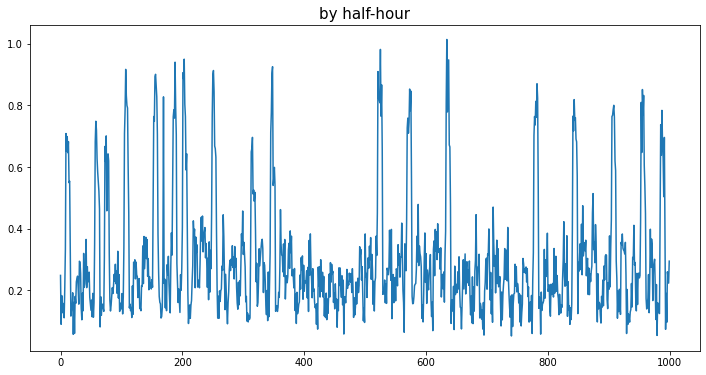

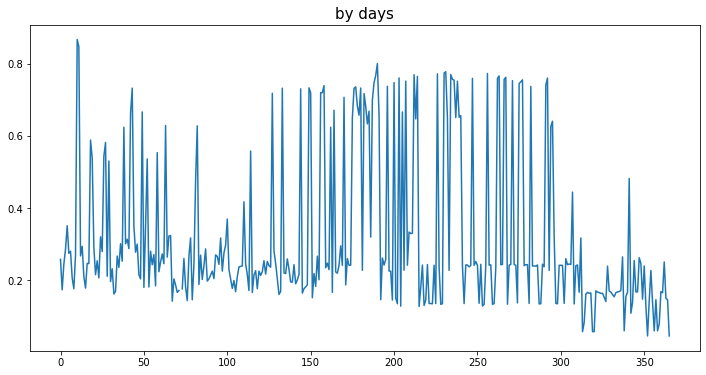

In [10]:
draw1=df1.values.reshape(1,-1)
draw1=draw1[0,:]
plt.figure(figsize=(12,6))
plt.plot(draw1[0:1000])#plt.plot(draw1[0:1000])
plt.title("by half-hour",fontsize='15') 

draw2=df1['48']
plt.figure(figsize=(12,6))
plt.plot(draw2)
plt.title("by days",fontsize='15') 

In [11]:
#进行数据归一化
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
df0=min_max_scaler.fit_transform(df1)
df = pd.DataFrame(df0, columns=df1.columns) 
#print(df1)
#print(df0)
#print(df)
#print(X)
#print(y)
print(df.shape)

(366, 48)


### 随机森林

In [18]:
from sklearn.utils import shuffle
time = [i for i in range(912)]
#划分时间窗口 将数据切片为sample和label
def time_slice(time,single,X_lag):
    sample = []
    label = []
    for k in range(len(time) - X_lag - 1):
        t = k + X_lag
        sample.append(single[k:t])
        label.append(single[t + 1])
    return sample,label
#这里选取后20天的数据
data = np.squeeze(df.iloc[-20:-1,].values.reshape(-1,1))
sample,label = time_slice(time,data,5)
from sklearn.model_selection import train_test_split
#数据集划分
X_train, X_test, y_train, y_test = train_test_split(sample, label, test_size=0.3, random_state=42)
#将数据顺序打乱
random_seed = 13
X_train, y_train = shuffle(X_train, y_train, random_state=random_seed)

In [19]:
#使用网格搜索优化模型参数

import warnings
warnings.filterwarnings("ignore")

# 建立随机森林模型 预测
from sklearn.ensemble import RandomForestRegressor
rf=RandomForestRegressor()
# 直接使用交叉网格搜索来优化决策树模型，边训练边优化
from sklearn.model_selection import GridSearchCV
# 网格搜索的参数：正常决策树建模中的参数 - 评估指标，树的深度，
 ## 最小拆分的叶子样本数与树的深度
param_grid = {
    'n_estimators': [n for n in range(30, 50)],
    'max_depth'   : [n for n in range(2, 6)],
    'max_features': [n for n in range(2, 6)]}
                # 通常来说，十几层的树已经是比较深了
#网格搜索中使用交叉验证
clfcv = GridSearchCV(estimator=rf, param_grid=param_grid, 
                            scoring='neg_mean_squared_log_error', cv=5) 
        # 传入模型，网格搜索的参数，评估指标，cv交叉验证的次数
      ## 这里也只是定义，还没有开始训练模型
model = clfcv.fit(X_train, y_train) 

Text(0.5, 1.0, 'Train Data')

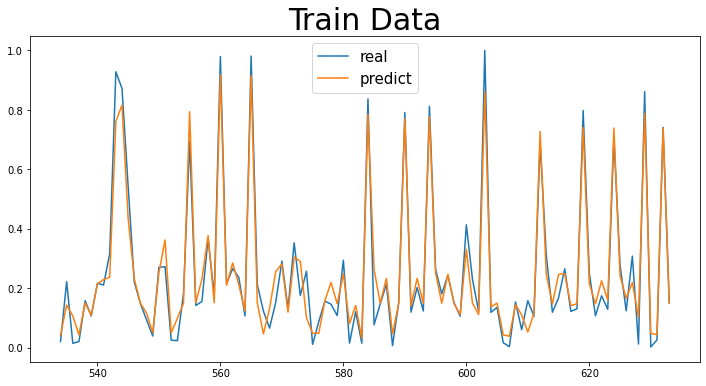

In [20]:
#在训练集上的拟合结果
y_train_predict=clfcv.predict(X_train)
#展示在训练集上的表现 
draw=pd.concat([pd.DataFrame(y_train),pd.DataFrame(y_train_predict)],axis=1)
draw.iloc[-100:,0].plot(figsize=(12,6))
draw.iloc[-100:,1].plot(figsize=(12,6))
plt.legend(('real', 'predict'),fontsize='15')
plt.title("Train Data",fontsize='30') #添加标题

Text(0.5, 1.0, 'Test Data')

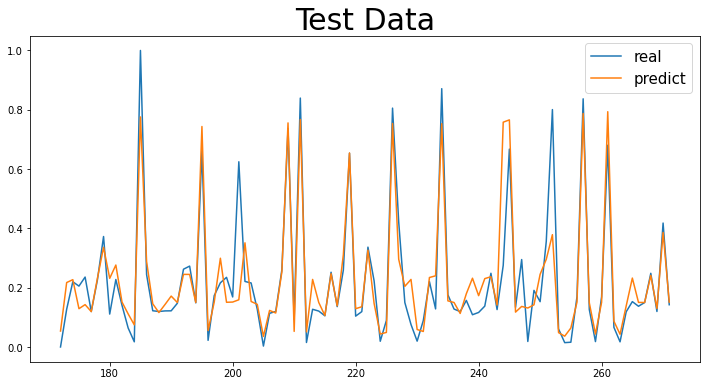

In [21]:
#在测试集上的预测
y_test_predict=clfcv.predict(X_test)
#展示在测试集上的表现 
draw=pd.concat([pd.DataFrame(y_test),pd.DataFrame(y_test_predict)],axis=1);
draw.iloc[-100:,0].plot(figsize=(12,6))
draw.iloc[-100:,1].plot(figsize=(12,6))
plt.legend(('real', 'predict'),loc='upper right',fontsize='15')
plt.title("Test Data",fontsize='30') #添加标题

In [22]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

print('训练集上的MAE/MSE/MAPE')
print(mean_absolute_error(y_train,y_train_predict))
print(mean_squared_error(y_train,y_train_predict,squared=False) )
print(mean_absolute_percentage_error(y_train,y_train_predict))
print('测试集上的MAE/MSE/MAPE')
print(mean_absolute_error(y_test,y_test_predict))
print(mean_squared_error(y_test,y_test_predict,squared=False) )
print(mean_absolute_percentage_error(y_test,y_test_predict) )

训练集上的MAE/MSE/MAPE
0.04375215569159716
0.06913352335736575
2593596427998.227
测试集上的MAE/MSE/MAPE
0.056925888674598635
0.10582018346050072
5965667478725.592


In [23]:
train_rf_mae=mean_absolute_error(y_train,y_train_predict)
train_rf_mse=mean_squared_error(y_train,y_train_predict,squared=False) 
train_rf_mape=mean_absolute_percentage_error(y_train,y_train_predict)

test_rf_mae=mean_absolute_error(y_test,y_test_predict)
test_rf_mse=mean_squared_error(y_test,y_test_predict,squared=False) 
test_rf_mape=mean_absolute_percentage_error(y_test,y_test_predict) 

### LSTM

In [29]:
#数据缺失引起梯度爆炸
pd.isnull(df).any() #数据中有缺失

1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10    False
11    False
12    False
13    False
14    False
15    False
16    False
17    False
18    False
19    False
20    False
21    False
22    False
23    False
24    False
25    False
26    False
27    False
28    False
29    False
30    False
31    False
32    False
33    False
34    False
35    False
36    False
37    False
38    False
39    False
40    False
41    False
42    False
43    False
44    False
45    False
46    False
47     True
48     True
dtype: bool

In [31]:
#使用每列缺失值前面的值进行填充(按相应列填充,按照相应index前后填充)
df.fillna(method='ffill',inplace=True)
pd.isnull(df).any()

1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10    False
11    False
12    False
13    False
14    False
15    False
16    False
17    False
18    False
19    False
20    False
21    False
22    False
23    False
24    False
25    False
26    False
27    False
28    False
29    False
30    False
31    False
32    False
33    False
34    False
35    False
36    False
37    False
38    False
39    False
40    False
41    False
42    False
43    False
44    False
45    False
46    False
47    False
48    False
dtype: bool

In [32]:
#设置LSTM、GRU的时间窗
window=5
#处理LSTM数据
stock=df
input_size = 48
seq_len=window
amount_of_features = len(stock.columns)#有几列
data = stock.values #pd.DataFrame(stock) 表格转化为矩阵
sequence_length = seq_len #序列长度5+1
result_x = []
result_y = []
for index in range(len(data) - sequence_length - 1):#循环
    result_x.append(data[index: index + sequence_length])#选取五天
    result_y.append(data[index + sequence_length + 1])#目标是后面的一天
result_x = np.array(result_x)
result_y = np.array(result_y)

row_x = round(0.9 * result_x.shape[0])#划分训练集测试集

x_train = result_x[:int(row_x)]
y_train = result_y[:int(row_x)]
x_test = result_x[int(row_x):]
y_test = result_y[int(row_x):]

# train = result[:int(row), :]
# x_train = train[:, :-1]
# y_train = train[:, -1][:,-1]
# x_test = result[int(row):, :-1]
# y_test = result[int(row):, -1][:,-1]

# # 测试集变array并reshape为符合RNN输入要求：[送入样本数， 循环核时间展开步数， 每个时间步输入特征个数]
X_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
X_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features)) 
y_train = np.reshape(y_train,(y_train.shape[0],-1,amount_of_features))
y_test = np.reshape(y_test,(y_test.shape[0],-1,amount_of_features))

In [33]:
X_train.shape
y_train.shape

(324, 1, 48)

In [50]:
#建立LSTM模型 训练
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.layers import LSTM, Flatten,MaxPooling1D,Conv1D
#建立、训练模型过程
model = Sequential()#建立层次模型
model.add(Dropout(0.25))
model.add(LSTM(256, input_shape=(window, input_size), dropout=0.05, return_sequences=False))#建立LSTM层 
# model.add(LSTM(64, input_shape=(window, input_size), dropout=0.05, return_sequences=False))#建立LSTM层  
# model.add(LSTM(48, input_shape=(window, input_size), dropout=0.5, return_sequences=False))#建立LSTM层  
model.add(Dense(amount_of_features,activation='tanh'))
model.compile(loss='mse',optimizer=tensorflow.keras.optimizers.Adam(0.001),metrics=['accuracy'])
#训练模型epochs次
#获得模型训练的信息，并加入验证集
history = model.fit(X_train, y_train, epochs =500, batch_size = 18,validation_split=0.2) 

Epoch 1/500
15/15 [==============================] - 3s 56ms/step - loss: 0.0882 - accuracy: 0.0232 - val_loss: 0.0719 - val_accuracy: 0.0308
Epoch 2/500
15/15 [==============================] - 0s 21ms/step - loss: 0.0650 - accuracy: 0.0309 - val_loss: 0.0580 - val_accuracy: 0.0000e+00
Epoch 3/500
15/15 [==============================] - 0s 21ms/step - loss: 0.0602 - accuracy: 0.0193 - val_loss: 0.0610 - val_accuracy: 0.0000e+00
Epoch 4/500
15/15 [==============================] - 0s 21ms/step - loss: 0.0593 - accuracy: 0.0541 - val_loss: 0.0631 - val_accuracy: 0.0000e+00
Epoch 5/500
15/15 [==============================] - 0s 21ms/step - loss: 0.0586 - accuracy: 0.0425 - val_loss: 0.0630 - val_accuracy: 0.0154
Epoch 6/500
15/15 [==============================] - 0s 21ms/step - loss: 0.0584 - accuracy: 0.0579 - val_loss: 0.0649 - val_accuracy: 0.0000e+00
Epoch 7/500
15/15 [==============================] - 0s 21ms/step - loss: 0.0588 - accuracy: 0.0347 - val_loss: 0.0619 - val_accurac

Epoch 58/500
15/15 [==============================] - 0s 20ms/step - loss: 0.0573 - accuracy: 0.0541 - val_loss: 0.0651 - val_accuracy: 0.0154
Epoch 59/500
15/15 [==============================] - 0s 20ms/step - loss: 0.0576 - accuracy: 0.0772 - val_loss: 0.0659 - val_accuracy: 0.0154
Epoch 60/500
15/15 [==============================] - 0s 19ms/step - loss: 0.0575 - accuracy: 0.0347 - val_loss: 0.0654 - val_accuracy: 0.0154
Epoch 61/500
15/15 [==============================] - 0s 20ms/step - loss: 0.0573 - accuracy: 0.0618 - val_loss: 0.0653 - val_accuracy: 0.0154
Epoch 62/500
15/15 [==============================] - 0s 20ms/step - loss: 0.0576 - accuracy: 0.0618 - val_loss: 0.0653 - val_accuracy: 0.0154
Epoch 63/500
15/15 [==============================] - 0s 19ms/step - loss: 0.0572 - accuracy: 0.0579 - val_loss: 0.0656 - val_accuracy: 0.0000e+00
Epoch 64/500
15/15 [==============================] - 0s 20ms/step - loss: 0.0575 - accuracy: 0.0772 - val_loss: 0.0652 - val_accuracy: 0.

Epoch 115/500
15/15 [==============================] - 0s 20ms/step - loss: 0.0573 - accuracy: 0.0502 - val_loss: 0.0657 - val_accuracy: 0.0154
Epoch 116/500
15/15 [==============================] - 0s 19ms/step - loss: 0.0572 - accuracy: 0.0849 - val_loss: 0.0661 - val_accuracy: 0.0308
Epoch 117/500
15/15 [==============================] - 0s 20ms/step - loss: 0.0572 - accuracy: 0.0656 - val_loss: 0.0651 - val_accuracy: 0.0308
Epoch 118/500
15/15 [==============================] - 0s 20ms/step - loss: 0.0574 - accuracy: 0.0734 - val_loss: 0.0655 - val_accuracy: 0.0462
Epoch 119/500
15/15 [==============================] - 0s 20ms/step - loss: 0.0574 - accuracy: 0.0463 - val_loss: 0.0659 - val_accuracy: 0.0615
Epoch 120/500
15/15 [==============================] - 0s 21ms/step - loss: 0.0574 - accuracy: 0.0425 - val_loss: 0.0651 - val_accuracy: 0.0154
Epoch 121/500
15/15 [==============================] - 0s 20ms/step - loss: 0.0573 - accuracy: 0.0618 - val_loss: 0.0656 - val_accuracy:

Epoch 172/500
15/15 [==============================] - 0s 20ms/step - loss: 0.0575 - accuracy: 0.0656 - val_loss: 0.0660 - val_accuracy: 0.0000e+00
Epoch 173/500
15/15 [==============================] - 0s 20ms/step - loss: 0.0570 - accuracy: 0.0425 - val_loss: 0.0661 - val_accuracy: 0.0154
Epoch 174/500
15/15 [==============================] - 0s 19ms/step - loss: 0.0572 - accuracy: 0.0347 - val_loss: 0.0661 - val_accuracy: 0.0000e+00
Epoch 175/500
15/15 [==============================] - 0s 20ms/step - loss: 0.0571 - accuracy: 0.0541 - val_loss: 0.0649 - val_accuracy: 0.0308
Epoch 176/500
15/15 [==============================] - 0s 19ms/step - loss: 0.0571 - accuracy: 0.0927 - val_loss: 0.0663 - val_accuracy: 0.0154
Epoch 177/500
15/15 [==============================] - 0s 20ms/step - loss: 0.0573 - accuracy: 0.0386 - val_loss: 0.0657 - val_accuracy: 0.0154
Epoch 178/500
15/15 [==============================] - 0s 20ms/step - loss: 0.0573 - accuracy: 0.0618 - val_loss: 0.0654 - val_a

Epoch 285/500
15/15 [==============================] - 0s 20ms/step - loss: 0.0570 - accuracy: 0.0386 - val_loss: 0.0657 - val_accuracy: 0.0000e+00
Epoch 286/500
15/15 [==============================] - 0s 21ms/step - loss: 0.0570 - accuracy: 0.0502 - val_loss: 0.0654 - val_accuracy: 0.0462
Epoch 287/500
15/15 [==============================] - 0s 20ms/step - loss: 0.0572 - accuracy: 0.0656 - val_loss: 0.0653 - val_accuracy: 0.0308
Epoch 288/500
15/15 [==============================] - 0s 20ms/step - loss: 0.0571 - accuracy: 0.0618 - val_loss: 0.0660 - val_accuracy: 0.0308
Epoch 289/500
15/15 [==============================] - 0s 20ms/step - loss: 0.0570 - accuracy: 0.0386 - val_loss: 0.0657 - val_accuracy: 0.0000e+00
Epoch 290/500
15/15 [==============================] - 0s 20ms/step - loss: 0.0575 - accuracy: 0.0618 - val_loss: 0.0652 - val_accuracy: 0.0154
Epoch 291/500
15/15 [==============================] - 0s 20ms/step - loss: 0.0579 - accuracy: 0.0579 - val_loss: 0.0655 - val_a

15/15 [==============================] - 0s 20ms/step - loss: 0.0571 - accuracy: 0.0811 - val_loss: 0.0655 - val_accuracy: 0.0615
Epoch 398/500
15/15 [==============================] - 0s 20ms/step - loss: 0.0571 - accuracy: 0.0618 - val_loss: 0.0663 - val_accuracy: 0.0462
Epoch 399/500
15/15 [==============================] - 0s 20ms/step - loss: 0.0572 - accuracy: 0.0425 - val_loss: 0.0663 - val_accuracy: 0.0000e+00
Epoch 400/500
15/15 [==============================] - 0s 20ms/step - loss: 0.0571 - accuracy: 0.0425 - val_loss: 0.0660 - val_accuracy: 0.0154
Epoch 401/500
15/15 [==============================] - 0s 20ms/step - loss: 0.0572 - accuracy: 0.0811 - val_loss: 0.0659 - val_accuracy: 0.0154
Epoch 402/500
15/15 [==============================] - 0s 20ms/step - loss: 0.0572 - accuracy: 0.0734 - val_loss: 0.0655 - val_accuracy: 0.0462
Epoch 403/500
15/15 [==============================] - 0s 20ms/step - loss: 0.0571 - accuracy: 0.0541 - val_loss: 0.0662 - val_accuracy: 0.0308
Ep

Epoch 454/500
15/15 [==============================] - 0s 20ms/step - loss: 0.0571 - accuracy: 0.0927 - val_loss: 0.0654 - val_accuracy: 0.0308
Epoch 455/500
15/15 [==============================] - 0s 20ms/step - loss: 0.0571 - accuracy: 0.0502 - val_loss: 0.0662 - val_accuracy: 0.0154
Epoch 456/500
15/15 [==============================] - 0s 20ms/step - loss: 0.0571 - accuracy: 0.0386 - val_loss: 0.0655 - val_accuracy: 0.0462
Epoch 457/500
15/15 [==============================] - 0s 20ms/step - loss: 0.0571 - accuracy: 0.0541 - val_loss: 0.0655 - val_accuracy: 0.0615
Epoch 458/500
15/15 [==============================] - 0s 22ms/step - loss: 0.0571 - accuracy: 0.0618 - val_loss: 0.0659 - val_accuracy: 0.0615
Epoch 459/500
15/15 [==============================] - 0s 21ms/step - loss: 0.0571 - accuracy: 0.0579 - val_loss: 0.0659 - val_accuracy: 0.0615
Epoch 460/500
15/15 [==============================] - 0s 20ms/step - loss: 0.0571 - accuracy: 0.0695 - val_loss: 0.0661 - val_accuracy:

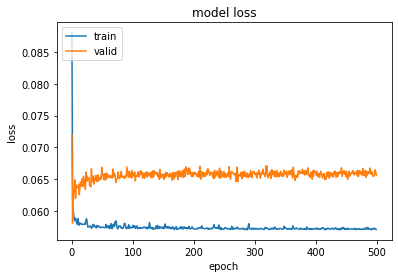

In [51]:
#下面曲线最终趋于平稳  模型收敛
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(loss, label='loss')
plt.plot(val_loss, label='val_loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')

11/11 [==============================] - 0s 8ms/step


Text(0.5, 1.0, 'Train Data')

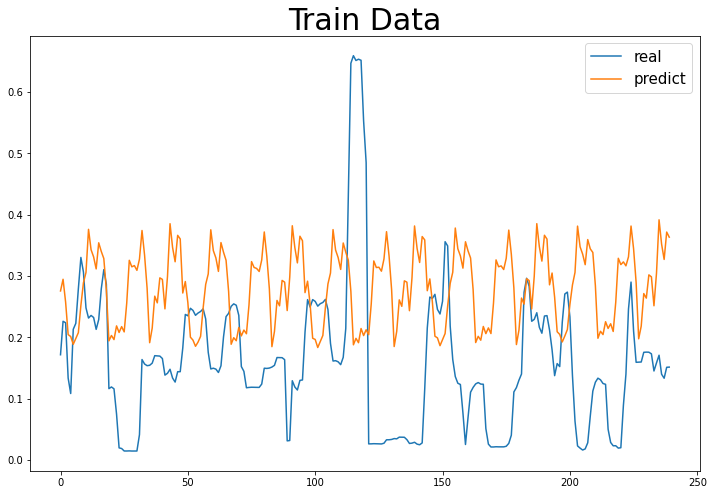

In [52]:
#在训练集上的拟合结果
y_train_predict=model.predict(X_train)#预测
y_t = y_train[-5:].reshape(-1,1)#改变形状
y_tp = y_train_predict[-5:].reshape(-1,1)
plt.figure(figsize=(12,8))
plt.plot(pd.DataFrame(y_t),label='real')#绘图
plt.plot(pd.DataFrame(y_tp),label='predict')
plt.legend(fontsize='15')
plt.title("Train Data",fontsize='30') #添加标题
#展示在训练集上的表现 

In [53]:
print(X_train.shape)
print(y_train.shape)
print(y_train_predict.shape)

(324, 5, 48)
(324, 1, 48)
(324, 48)


2/2 [==============================] - 0s 5ms/step


Text(0.5, 1.0, 'Test Data')

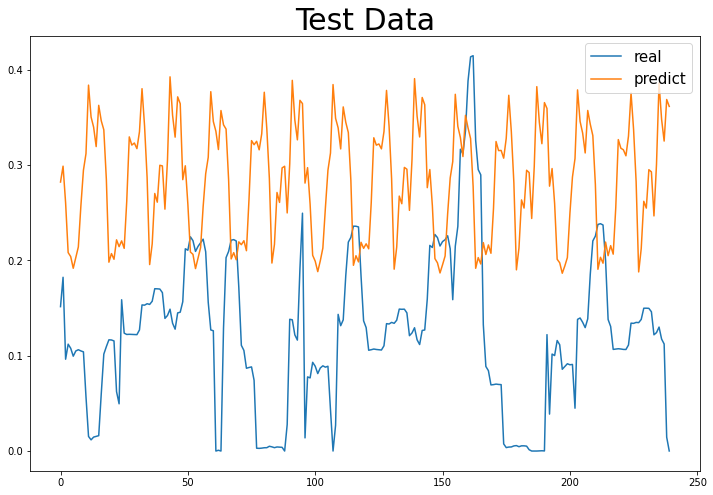

In [54]:
#在测试集上的预测
y_test_predict=model.predict(X_test)
y_t = y_test[-5:].reshape(-1,1)
y_tp = y_test_predict[-5:].reshape(-1,1)
plt.figure(figsize=(12,8))
plt.plot(pd.DataFrame(y_t),label='real')
plt.plot(pd.DataFrame(y_tp),label='predict')
plt.legend(fontsize='15')
plt.title("Test Data",fontsize='30') #添加标题
#展示在测试集上的表现 

In [39]:
print(X_test.shape)
print(y_test.shape)
print(y_test_predict.shape)

(36, 5, 48)
(36, 1, 48)
(36, 48)


In [55]:
#输出结果
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

print('训练集上的MAE/MSE/MAPE')
print(mean_absolute_error(y_train.reshape(-1,1),y_train_predict.reshape(-1,1)))
print(mean_squared_error(y_train.reshape(-1,1),y_train_predict.reshape(-1,1),squared=False) )
print(mean_absolute_percentage_error(y_train.reshape(-1,1),y_train_predict.reshape(-1,1)))
print('测试集上的MAE/MSE/MAPE')
print(mean_absolute_error(y_test.reshape(-1,1),y_test_predict.reshape(-1,1)))
print(mean_squared_error(y_test.reshape(-1,1),y_test_predict.reshape(-1,1),squared=False) )
print(mean_absolute_percentage_error(y_test.reshape(-1,1),y_test_predict.reshape(-1,1)) )

训练集上的MAE/MSE/MAPE
0.18384226188951644
0.23992362344161888
2785098643820.6416
测试集上的MAE/MSE/MAPE
0.16687175985260458
0.20640253517150833
9684242913822.166


In [58]:
#将计算结果存储起来
train_lstm_mae=mean_absolute_error(y_train.reshape(-1,1),y_train_predict.reshape(-1,1))
train_lstm_mse=mean_squared_error(y_train.reshape(-1,1),y_train_predict.reshape(-1,1),squared=False) 
train_lstm_mape=mean_absolute_percentage_error(y_train.reshape(-1,1),y_train_predict.reshape(-1,1))

test_lstm_mae=mean_absolute_error(y_test.reshape(-1,1),y_test_predict.reshape(-1,1))
test_lstm_mse=mean_squared_error(y_test.reshape(-1,1),y_test_predict.reshape(-1,1),squared=False) 
test_lstm_mape=mean_absolute_percentage_error(y_test.reshape(-1,1),y_test_predict.reshape(-1,1)) 

### GRU

In [82]:
#建立GRU模型 训练
from tensorflow.keras.layers import GRU
#建立、训练模型过程
d = 0.01
model = Sequential()#建立层次模型
model.add(GRU(128, input_shape=(window, input_size), return_sequences=False))#建立LSTM层
model.add(Dropout(d))#建立的遗忘层
# model.add(GRU(64, input_shape=(window, input_size), return_sequences=False))#建立LSTM层
# model.add(Dropout(d))#建立的遗忘层
model.add(Dense(amount_of_features,activation='tanh'))
model.compile(loss='mse',optimizer=tensorflow.keras.optimizers.Adam(0.01),metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs =1500, batch_size = 256,validation_split=0.2) #训练模型nb_epoch次

Epoch 1/1500
2/2 [==============================] - 2s 494ms/step - loss: 0.1770 - accuracy: 0.0270 - val_loss: 0.1020 - val_accuracy: 0.0000e+00
Epoch 2/1500
2/2 [==============================] - 0s 53ms/step - loss: 0.0912 - accuracy: 0.0386 - val_loss: 0.1153 - val_accuracy: 0.0154
Epoch 3/1500
2/2 [==============================] - 0s 54ms/step - loss: 0.0939 - accuracy: 0.0309 - val_loss: 0.0879 - val_accuracy: 0.0000e+00
Epoch 4/1500
2/2 [==============================] - 0s 54ms/step - loss: 0.0781 - accuracy: 0.0039 - val_loss: 0.0832 - val_accuracy: 0.0000e+00
Epoch 5/1500
2/2 [==============================] - 0s 48ms/step - loss: 0.0800 - accuracy: 0.0232 - val_loss: 0.0823 - val_accuracy: 0.0154
Epoch 6/1500
2/2 [==============================] - 0s 49ms/step - loss: 0.0747 - accuracy: 0.0309 - val_loss: 0.0915 - val_accuracy: 0.0000e+00
Epoch 7/1500
2/2 [==============================] - 0s 51ms/step - loss: 0.0795 - accuracy: 0.0193 - val_loss: 0.0785 - val_accuracy: 0.0

Epoch 115/1500
2/2 [==============================] - 0s 46ms/step - loss: 0.0585 - accuracy: 0.0811 - val_loss: 0.0666 - val_accuracy: 0.0154
Epoch 116/1500
2/2 [==============================] - 0s 46ms/step - loss: 0.0592 - accuracy: 0.0734 - val_loss: 0.0658 - val_accuracy: 0.0154
Epoch 117/1500
2/2 [==============================] - 0s 45ms/step - loss: 0.0596 - accuracy: 0.0927 - val_loss: 0.0655 - val_accuracy: 0.0154
Epoch 118/1500
2/2 [==============================] - 0s 51ms/step - loss: 0.0597 - accuracy: 0.0888 - val_loss: 0.0652 - val_accuracy: 0.0000e+00
Epoch 119/1500
2/2 [==============================] - 0s 50ms/step - loss: 0.0592 - accuracy: 0.0849 - val_loss: 0.0651 - val_accuracy: 0.0000e+00
Epoch 120/1500
2/2 [==============================] - 0s 49ms/step - loss: 0.0593 - accuracy: 0.0695 - val_loss: 0.0655 - val_accuracy: 0.0000e+00
Epoch 121/1500
2/2 [==============================] - 0s 47ms/step - loss: 0.0599 - accuracy: 0.0579 - val_loss: 0.0664 - val_accu

Epoch 228/1500
2/2 [==============================] - 0s 48ms/step - loss: 0.0579 - accuracy: 0.0849 - val_loss: 0.0644 - val_accuracy: 0.0154
Epoch 229/1500
2/2 [==============================] - 0s 46ms/step - loss: 0.0578 - accuracy: 0.0849 - val_loss: 0.0638 - val_accuracy: 0.0154
Epoch 230/1500
2/2 [==============================] - 0s 49ms/step - loss: 0.0578 - accuracy: 0.0811 - val_loss: 0.0635 - val_accuracy: 0.0154
Epoch 231/1500
2/2 [==============================] - 0s 46ms/step - loss: 0.0579 - accuracy: 0.0811 - val_loss: 0.0636 - val_accuracy: 0.0154
Epoch 232/1500
2/2 [==============================] - 0s 47ms/step - loss: 0.0580 - accuracy: 0.0849 - val_loss: 0.0638 - val_accuracy: 0.0154
Epoch 233/1500
2/2 [==============================] - 0s 50ms/step - loss: 0.0582 - accuracy: 0.0849 - val_loss: 0.0639 - val_accuracy: 0.0154
Epoch 234/1500
2/2 [==============================] - 0s 49ms/step - loss: 0.0583 - accuracy: 0.0849 - val_loss: 0.0639 - val_accuracy: 0.0154

Epoch 341/1500
2/2 [==============================] - 0s 46ms/step - loss: 0.0584 - accuracy: 0.0386 - val_loss: 0.0679 - val_accuracy: 0.0000e+00
Epoch 342/1500
2/2 [==============================] - 0s 46ms/step - loss: 0.0583 - accuracy: 0.0386 - val_loss: 0.0663 - val_accuracy: 0.0000e+00
Epoch 343/1500
2/2 [==============================] - 0s 52ms/step - loss: 0.0579 - accuracy: 0.0386 - val_loss: 0.0652 - val_accuracy: 0.0000e+00
Epoch 344/1500
2/2 [==============================] - 0s 46ms/step - loss: 0.0581 - accuracy: 0.0309 - val_loss: 0.0646 - val_accuracy: 0.0000e+00
Epoch 345/1500
2/2 [==============================] - 0s 50ms/step - loss: 0.0582 - accuracy: 0.0193 - val_loss: 0.0643 - val_accuracy: 0.0000e+00
Epoch 346/1500
2/2 [==============================] - 0s 48ms/step - loss: 0.0579 - accuracy: 0.0039 - val_loss: 0.0644 - val_accuracy: 0.0000e+00
Epoch 347/1500
2/2 [==============================] - 0s 46ms/step - loss: 0.0577 - accuracy: 0.0232 - val_loss: 0.065

Epoch 398/1500
2/2 [==============================] - 0s 45ms/step - loss: 0.0581 - accuracy: 0.0386 - val_loss: 0.0680 - val_accuracy: 0.0000e+00
Epoch 399/1500
2/2 [==============================] - 0s 46ms/step - loss: 0.0582 - accuracy: 0.0425 - val_loss: 0.0682 - val_accuracy: 0.0000e+00
Epoch 400/1500
2/2 [==============================] - 0s 47ms/step - loss: 0.0583 - accuracy: 0.0386 - val_loss: 0.0681 - val_accuracy: 0.0000e+00
Epoch 401/1500
2/2 [==============================] - 0s 47ms/step - loss: 0.0582 - accuracy: 0.0386 - val_loss: 0.0680 - val_accuracy: 0.0000e+00
Epoch 402/1500
2/2 [==============================] - 0s 46ms/step - loss: 0.0582 - accuracy: 0.0386 - val_loss: 0.0674 - val_accuracy: 0.0154
Epoch 403/1500
2/2 [==============================] - 0s 48ms/step - loss: 0.0581 - accuracy: 0.0386 - val_loss: 0.0668 - val_accuracy: 0.0154
Epoch 404/1500
2/2 [==============================] - 0s 51ms/step - loss: 0.0580 - accuracy: 0.0618 - val_loss: 0.0668 - val_

Epoch 455/1500
2/2 [==============================] - 0s 45ms/step - loss: 0.0596 - accuracy: 0.0386 - val_loss: 0.0669 - val_accuracy: 0.0154
Epoch 456/1500
2/2 [==============================] - 0s 48ms/step - loss: 0.0601 - accuracy: 0.0386 - val_loss: 0.0669 - val_accuracy: 0.0154
Epoch 457/1500
2/2 [==============================] - 0s 49ms/step - loss: 0.0597 - accuracy: 0.0386 - val_loss: 0.0664 - val_accuracy: 0.0154
Epoch 458/1500
2/2 [==============================] - 0s 51ms/step - loss: 0.0588 - accuracy: 0.0386 - val_loss: 0.0659 - val_accuracy: 0.0000e+00
Epoch 459/1500
2/2 [==============================] - 0s 54ms/step - loss: 0.0580 - accuracy: 0.0425 - val_loss: 0.0660 - val_accuracy: 0.0154
Epoch 460/1500
2/2 [==============================] - 0s 45ms/step - loss: 0.0574 - accuracy: 0.0541 - val_loss: 0.0660 - val_accuracy: 0.0308
Epoch 461/1500
2/2 [==============================] - 0s 45ms/step - loss: 0.0573 - accuracy: 0.0502 - val_loss: 0.0661 - val_accuracy: 0.

Epoch 512/1500
2/2 [==============================] - 0s 43ms/step - loss: 0.0574 - accuracy: 0.0927 - val_loss: 0.0647 - val_accuracy: 0.0154
Epoch 513/1500
2/2 [==============================] - 0s 50ms/step - loss: 0.0575 - accuracy: 0.0811 - val_loss: 0.0640 - val_accuracy: 0.0154
Epoch 514/1500
2/2 [==============================] - 0s 50ms/step - loss: 0.0576 - accuracy: 0.0656 - val_loss: 0.0638 - val_accuracy: 0.0154
Epoch 515/1500
2/2 [==============================] - 0s 47ms/step - loss: 0.0578 - accuracy: 0.0618 - val_loss: 0.0642 - val_accuracy: 0.0308
Epoch 516/1500
2/2 [==============================] - 0s 50ms/step - loss: 0.0579 - accuracy: 0.0618 - val_loss: 0.0652 - val_accuracy: 0.0462
Epoch 517/1500
2/2 [==============================] - 0s 50ms/step - loss: 0.0580 - accuracy: 0.0618 - val_loss: 0.0661 - val_accuracy: 0.0615
Epoch 518/1500
2/2 [==============================] - 0s 52ms/step - loss: 0.0581 - accuracy: 0.0618 - val_loss: 0.0666 - val_accuracy: 0.0615

Epoch 625/1500
2/2 [==============================] - 0s 49ms/step - loss: 0.0582 - accuracy: 0.0386 - val_loss: 0.0679 - val_accuracy: 0.0000e+00
Epoch 626/1500
2/2 [==============================] - 0s 47ms/step - loss: 0.0581 - accuracy: 0.0386 - val_loss: 0.0683 - val_accuracy: 0.0000e+00
Epoch 627/1500
2/2 [==============================] - 0s 45ms/step - loss: 0.0580 - accuracy: 0.0386 - val_loss: 0.0684 - val_accuracy: 0.0000e+00
Epoch 628/1500
2/2 [==============================] - 0s 46ms/step - loss: 0.0579 - accuracy: 0.0386 - val_loss: 0.0685 - val_accuracy: 0.0000e+00
Epoch 629/1500
2/2 [==============================] - 0s 46ms/step - loss: 0.0578 - accuracy: 0.0386 - val_loss: 0.0690 - val_accuracy: 0.0000e+00
Epoch 630/1500
2/2 [==============================] - 0s 45ms/step - loss: 0.0579 - accuracy: 0.0502 - val_loss: 0.0695 - val_accuracy: 0.0000e+00
Epoch 631/1500
2/2 [==============================] - 0s 51ms/step - loss: 0.0579 - accuracy: 0.0618 - val_loss: 0.069

2/2 [==============================] - 0s 48ms/step - loss: 0.0576 - accuracy: 0.0772 - val_loss: 0.0655 - val_accuracy: 0.0154
Epoch 683/1500
2/2 [==============================] - 0s 60ms/step - loss: 0.0574 - accuracy: 0.0734 - val_loss: 0.0661 - val_accuracy: 0.0154
Epoch 684/1500
2/2 [==============================] - 0s 50ms/step - loss: 0.0573 - accuracy: 0.0656 - val_loss: 0.0667 - val_accuracy: 0.0154
Epoch 685/1500
2/2 [==============================] - 0s 48ms/step - loss: 0.0573 - accuracy: 0.0541 - val_loss: 0.0668 - val_accuracy: 0.0154
Epoch 686/1500
2/2 [==============================] - 0s 48ms/step - loss: 0.0573 - accuracy: 0.0618 - val_loss: 0.0668 - val_accuracy: 0.0154
Epoch 687/1500
2/2 [==============================] - 0s 52ms/step - loss: 0.0573 - accuracy: 0.0463 - val_loss: 0.0671 - val_accuracy: 0.0000e+00
Epoch 688/1500
2/2 [==============================] - 0s 48ms/step - loss: 0.0574 - accuracy: 0.0425 - val_loss: 0.0673 - val_accuracy: 0.0000e+00
Epoch 

Epoch 739/1500
2/2 [==============================] - 0s 53ms/step - loss: 0.0583 - accuracy: 0.0656 - val_loss: 0.0679 - val_accuracy: 0.0615
Epoch 740/1500
2/2 [==============================] - 0s 52ms/step - loss: 0.0600 - accuracy: 0.0618 - val_loss: 0.0688 - val_accuracy: 0.0615
Epoch 741/1500
2/2 [==============================] - 0s 52ms/step - loss: 0.0619 - accuracy: 0.0695 - val_loss: 0.0689 - val_accuracy: 0.0615
Epoch 742/1500
2/2 [==============================] - 0s 51ms/step - loss: 0.0626 - accuracy: 0.0618 - val_loss: 0.0683 - val_accuracy: 0.0615
Epoch 743/1500
2/2 [==============================] - 0s 46ms/step - loss: 0.0626 - accuracy: 0.0425 - val_loss: 0.0673 - val_accuracy: 0.0615
Epoch 744/1500
2/2 [==============================] - 0s 51ms/step - loss: 0.0619 - accuracy: 0.0425 - val_loss: 0.0665 - val_accuracy: 0.0615
Epoch 745/1500
2/2 [==============================] - 0s 47ms/step - loss: 0.0612 - accuracy: 0.0425 - val_loss: 0.0658 - val_accuracy: 0.0462

2/2 [==============================] - 0s 47ms/step - loss: 0.0578 - accuracy: 0.0386 - val_loss: 0.0674 - val_accuracy: 0.0154
Epoch 797/1500
2/2 [==============================] - 0s 49ms/step - loss: 0.0575 - accuracy: 0.0386 - val_loss: 0.0667 - val_accuracy: 0.0000e+00
Epoch 798/1500
2/2 [==============================] - 0s 47ms/step - loss: 0.0573 - accuracy: 0.0386 - val_loss: 0.0662 - val_accuracy: 0.0000e+00
Epoch 799/1500
2/2 [==============================] - 0s 50ms/step - loss: 0.0572 - accuracy: 0.0386 - val_loss: 0.0658 - val_accuracy: 0.0000e+00
Epoch 800/1500
2/2 [==============================] - 0s 45ms/step - loss: 0.0571 - accuracy: 0.0386 - val_loss: 0.0657 - val_accuracy: 0.0000e+00
Epoch 801/1500
2/2 [==============================] - 0s 46ms/step - loss: 0.0571 - accuracy: 0.0386 - val_loss: 0.0657 - val_accuracy: 0.0000e+00
Epoch 802/1500
2/2 [==============================] - 0s 52ms/step - loss: 0.0572 - accuracy: 0.0386 - val_loss: 0.0656 - val_accuracy: 0

Epoch 853/1500
2/2 [==============================] - 0s 46ms/step - loss: 0.0587 - accuracy: 0.0656 - val_loss: 0.0668 - val_accuracy: 0.0154
Epoch 854/1500
2/2 [==============================] - 0s 46ms/step - loss: 0.0584 - accuracy: 0.0618 - val_loss: 0.0657 - val_accuracy: 0.0154
Epoch 855/1500
2/2 [==============================] - 0s 49ms/step - loss: 0.0582 - accuracy: 0.0618 - val_loss: 0.0648 - val_accuracy: 0.0154
Epoch 856/1500
2/2 [==============================] - 0s 51ms/step - loss: 0.0579 - accuracy: 0.0386 - val_loss: 0.0643 - val_accuracy: 0.0000e+00
Epoch 857/1500
2/2 [==============================] - 0s 50ms/step - loss: 0.0576 - accuracy: 0.0386 - val_loss: 0.0642 - val_accuracy: 0.0000e+00
Epoch 858/1500
2/2 [==============================] - 0s 56ms/step - loss: 0.0575 - accuracy: 0.0386 - val_loss: 0.0645 - val_accuracy: 0.0000e+00
Epoch 859/1500
2/2 [==============================] - 0s 46ms/step - loss: 0.0574 - accuracy: 0.0386 - val_loss: 0.0649 - val_accu

Epoch 966/1500
2/2 [==============================] - 0s 51ms/step - loss: 0.0573 - accuracy: 0.0695 - val_loss: 0.0667 - val_accuracy: 0.0615
Epoch 967/1500
2/2 [==============================] - 0s 54ms/step - loss: 0.0573 - accuracy: 0.0772 - val_loss: 0.0666 - val_accuracy: 0.0615
Epoch 968/1500
2/2 [==============================] - 0s 46ms/step - loss: 0.0573 - accuracy: 0.0618 - val_loss: 0.0664 - val_accuracy: 0.0615
Epoch 969/1500
2/2 [==============================] - 0s 50ms/step - loss: 0.0573 - accuracy: 0.0618 - val_loss: 0.0663 - val_accuracy: 0.0615
Epoch 970/1500
2/2 [==============================] - 0s 48ms/step - loss: 0.0574 - accuracy: 0.0425 - val_loss: 0.0665 - val_accuracy: 0.0615
Epoch 971/1500
2/2 [==============================] - 0s 49ms/step - loss: 0.0575 - accuracy: 0.0425 - val_loss: 0.0666 - val_accuracy: 0.0615
Epoch 972/1500
2/2 [==============================] - 0s 48ms/step - loss: 0.0575 - accuracy: 0.0425 - val_loss: 0.0665 - val_accuracy: 0.0615

Epoch 1023/1500
2/2 [==============================] - 0s 44ms/step - loss: 0.0575 - accuracy: 0.0849 - val_loss: 0.0658 - val_accuracy: 0.0154
Epoch 1024/1500
2/2 [==============================] - 0s 48ms/step - loss: 0.0575 - accuracy: 0.0811 - val_loss: 0.0658 - val_accuracy: 0.0154
Epoch 1025/1500
2/2 [==============================] - 0s 52ms/step - loss: 0.0575 - accuracy: 0.0849 - val_loss: 0.0659 - val_accuracy: 0.0154
Epoch 1026/1500
2/2 [==============================] - 0s 48ms/step - loss: 0.0575 - accuracy: 0.0849 - val_loss: 0.0660 - val_accuracy: 0.0154
Epoch 1027/1500
2/2 [==============================] - 0s 47ms/step - loss: 0.0575 - accuracy: 0.0811 - val_loss: 0.0662 - val_accuracy: 0.0154
Epoch 1028/1500
2/2 [==============================] - 0s 50ms/step - loss: 0.0574 - accuracy: 0.0849 - val_loss: 0.0663 - val_accuracy: 0.0154
Epoch 1029/1500
2/2 [==============================] - 0s 47ms/step - loss: 0.0574 - accuracy: 0.0927 - val_loss: 0.0664 - val_accuracy:

Epoch 1136/1500
2/2 [==============================] - 0s 47ms/step - loss: 0.0574 - accuracy: 0.0849 - val_loss: 0.0644 - val_accuracy: 0.0154
Epoch 1137/1500
2/2 [==============================] - 0s 48ms/step - loss: 0.0574 - accuracy: 0.0849 - val_loss: 0.0642 - val_accuracy: 0.0154
Epoch 1138/1500
2/2 [==============================] - 0s 50ms/step - loss: 0.0575 - accuracy: 0.0849 - val_loss: 0.0640 - val_accuracy: 0.0154
Epoch 1139/1500
2/2 [==============================] - 0s 52ms/step - loss: 0.0575 - accuracy: 0.0849 - val_loss: 0.0639 - val_accuracy: 0.0154
Epoch 1140/1500
2/2 [==============================] - 0s 59ms/step - loss: 0.0575 - accuracy: 0.0849 - val_loss: 0.0640 - val_accuracy: 0.0154
Epoch 1141/1500
2/2 [==============================] - 0s 62ms/step - loss: 0.0576 - accuracy: 0.0849 - val_loss: 0.0643 - val_accuracy: 0.0154
Epoch 1142/1500
2/2 [==============================] - 0s 55ms/step - loss: 0.0576 - accuracy: 0.0811 - val_loss: 0.0646 - val_accuracy:

Epoch 1193/1500
2/2 [==============================] - 0s 52ms/step - loss: 0.0576 - accuracy: 0.0618 - val_loss: 0.0674 - val_accuracy: 0.0462
Epoch 1194/1500
2/2 [==============================] - 0s 53ms/step - loss: 0.0580 - accuracy: 0.0579 - val_loss: 0.0677 - val_accuracy: 0.0308
Epoch 1195/1500
2/2 [==============================] - 0s 51ms/step - loss: 0.0582 - accuracy: 0.0618 - val_loss: 0.0678 - val_accuracy: 0.0308
Epoch 1196/1500
2/2 [==============================] - 0s 50ms/step - loss: 0.0583 - accuracy: 0.0618 - val_loss: 0.0678 - val_accuracy: 0.0462
Epoch 1197/1500
2/2 [==============================] - 0s 50ms/step - loss: 0.0582 - accuracy: 0.0618 - val_loss: 0.0676 - val_accuracy: 0.0462
Epoch 1198/1500
2/2 [==============================] - 0s 47ms/step - loss: 0.0582 - accuracy: 0.0579 - val_loss: 0.0674 - val_accuracy: 0.0154
Epoch 1199/1500
2/2 [==============================] - 0s 47ms/step - loss: 0.0581 - accuracy: 0.0772 - val_loss: 0.0674 - val_accuracy:

Epoch 1250/1500
2/2 [==============================] - 0s 47ms/step - loss: 0.0572 - accuracy: 0.0463 - val_loss: 0.0652 - val_accuracy: 0.0154
Epoch 1251/1500
2/2 [==============================] - 0s 45ms/step - loss: 0.0572 - accuracy: 0.0425 - val_loss: 0.0656 - val_accuracy: 0.0154
Epoch 1252/1500
2/2 [==============================] - 0s 52ms/step - loss: 0.0573 - accuracy: 0.0425 - val_loss: 0.0660 - val_accuracy: 0.0000e+00
Epoch 1253/1500
2/2 [==============================] - 0s 48ms/step - loss: 0.0574 - accuracy: 0.0386 - val_loss: 0.0662 - val_accuracy: 0.0000e+00
Epoch 1254/1500
2/2 [==============================] - 0s 46ms/step - loss: 0.0574 - accuracy: 0.0386 - val_loss: 0.0664 - val_accuracy: 0.0000e+00
Epoch 1255/1500
2/2 [==============================] - 0s 49ms/step - loss: 0.0574 - accuracy: 0.0386 - val_loss: 0.0663 - val_accuracy: 0.0000e+00
Epoch 1256/1500
2/2 [==============================] - 0s 46ms/step - loss: 0.0574 - accuracy: 0.0386 - val_loss: 0.0663

2/2 [==============================] - 0s 55ms/step - loss: 0.0576 - accuracy: 0.0502 - val_loss: 0.0646 - val_accuracy: 0.0000e+00
Epoch 1363/1500
2/2 [==============================] - 0s 53ms/step - loss: 0.0576 - accuracy: 0.0463 - val_loss: 0.0648 - val_accuracy: 0.0000e+00
Epoch 1364/1500
2/2 [==============================] - 0s 53ms/step - loss: 0.0575 - accuracy: 0.0463 - val_loss: 0.0651 - val_accuracy: 0.0000e+00
Epoch 1365/1500
2/2 [==============================] - 0s 48ms/step - loss: 0.0575 - accuracy: 0.0463 - val_loss: 0.0654 - val_accuracy: 0.0000e+00
Epoch 1366/1500
2/2 [==============================] - 0s 51ms/step - loss: 0.0575 - accuracy: 0.0541 - val_loss: 0.0654 - val_accuracy: 0.0000e+00
Epoch 1367/1500
2/2 [==============================] - 0s 46ms/step - loss: 0.0574 - accuracy: 0.0579 - val_loss: 0.0653 - val_accuracy: 0.0308
Epoch 1368/1500
2/2 [==============================] - 0s 48ms/step - loss: 0.0573 - accuracy: 0.0618 - val_loss: 0.0651 - val_accur

Epoch 1419/1500
2/2 [==============================] - 0s 51ms/step - loss: 0.0575 - accuracy: 0.0656 - val_loss: 0.0640 - val_accuracy: 0.0615
Epoch 1420/1500
2/2 [==============================] - 0s 49ms/step - loss: 0.0574 - accuracy: 0.0656 - val_loss: 0.0644 - val_accuracy: 0.0615
Epoch 1421/1500
2/2 [==============================] - 0s 48ms/step - loss: 0.0575 - accuracy: 0.0734 - val_loss: 0.0652 - val_accuracy: 0.0615
Epoch 1422/1500
2/2 [==============================] - 0s 46ms/step - loss: 0.0576 - accuracy: 0.0656 - val_loss: 0.0660 - val_accuracy: 0.0615
Epoch 1423/1500
2/2 [==============================] - 0s 48ms/step - loss: 0.0578 - accuracy: 0.0618 - val_loss: 0.0666 - val_accuracy: 0.0615
Epoch 1424/1500
2/2 [==============================] - 0s 50ms/step - loss: 0.0579 - accuracy: 0.0502 - val_loss: 0.0671 - val_accuracy: 0.0615
Epoch 1425/1500
2/2 [==============================] - 0s 53ms/step - loss: 0.0579 - accuracy: 0.0502 - val_loss: 0.0674 - val_accuracy:

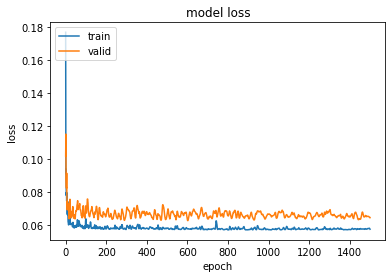

In [83]:
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(loss, label='loss')
plt.plot(val_loss, label='val_loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')

11/11 [==============================] - 0s 5ms/step


Text(0.5, 1.0, 'Train Data')

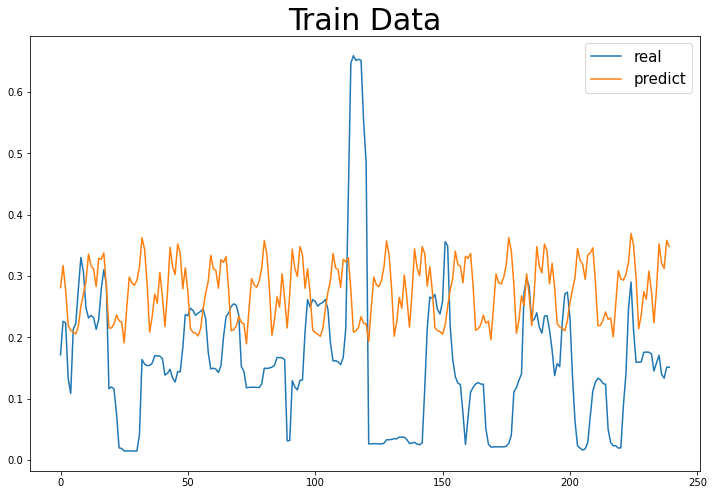

In [84]:
#在训练集上的拟合结果
y_train_predict=model.predict(X_train)
y_t = y_train[-5:].reshape(-1,1)
y_tp = y_train_predict[-5:].reshape(-1,1)
plt.figure(figsize=(12,8))
plt.plot(pd.DataFrame(y_t),label='real')
plt.plot(pd.DataFrame(y_tp),label='predict')
plt.legend(fontsize='15')
plt.title("Train Data",fontsize='30') #添加标题
#展示在训练集上的表现 

In [85]:
print(X_train.shape)
print(y_train.shape)
print(y_train_predict.shape)

(324, 5, 48)
(324, 1, 48)
(324, 48)


2/2 [==============================] - 0s 4ms/step


Text(0.5, 1.0, 'Test Data')

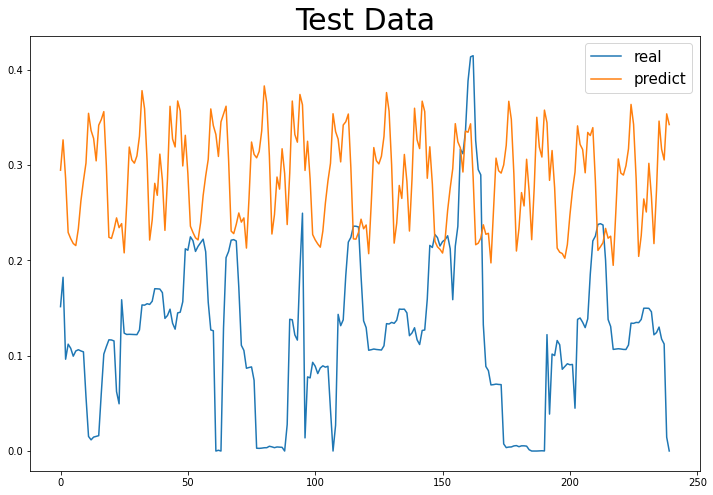

In [86]:
#在测试集上的预测
y_test_predict=model.predict(X_test)
y_t = y_test[-5:].reshape(-1,1)
y_tp = y_test_predict[-5:].reshape(-1,1)
plt.figure(figsize=(12,8))
plt.plot(pd.DataFrame(y_t),label='real')
plt.plot(pd.DataFrame(y_tp),label='predict')
plt.legend(fontsize='15')
plt.title("Test Data",fontsize='30') #添加标题
#展示在测试集上的表现 

In [87]:
#输出结果
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

print('训练集上的MAE/MSE/MAPE')
print(mean_absolute_error(y_train.reshape(-1,1),y_train_predict.reshape(-1,1)))
print(mean_squared_error(y_train.reshape(-1,1),y_train_predict.reshape(-1,1),squared=False) )
print(mean_absolute_percentage_error(y_train.reshape(-1,1),y_train_predict.reshape(-1,1)))
print('测试集上的MAE/MSE/MAPE')
print(mean_absolute_error(y_test.reshape(-1,1),y_test_predict.reshape(-1,1)))
print(mean_squared_error(y_test.reshape(-1,1),y_test_predict.reshape(-1,1),squared=False) )
print(mean_absolute_percentage_error(y_test.reshape(-1,1),y_test_predict.reshape(-1,1)) )

训练集上的MAE/MSE/MAPE
0.17845670472593245
0.23813848342324345
2736101185799.424
测试集上的MAE/MSE/MAPE
0.1607252628239132
0.19996384369167278
9193315281589.447


In [88]:
train_gru_mae=mean_absolute_error(y_train.reshape(-1,1),y_train_predict.reshape(-1,1))
train_gru_mse=mean_squared_error(y_train.reshape(-1,1),y_train_predict.reshape(-1,1),squared=False) 
train_gru_mape=mean_absolute_percentage_error(y_train.reshape(-1,1),y_train_predict.reshape(-1,1))

test_gru_mae=mean_absolute_error(y_test.reshape(-1,1),y_test_predict.reshape(-1,1))
test_gru_mse=mean_squared_error(y_test.reshape(-1,1),y_test_predict.reshape(-1,1),squared=False) 
test_gru_mape=mean_absolute_percentage_error(y_test.reshape(-1,1),y_test_predict.reshape(-1,1)) 

### 画图

[Text(0, 0, 'rf'), Text(1, 0, 'lstm'), Text(2, 0, 'gru')]

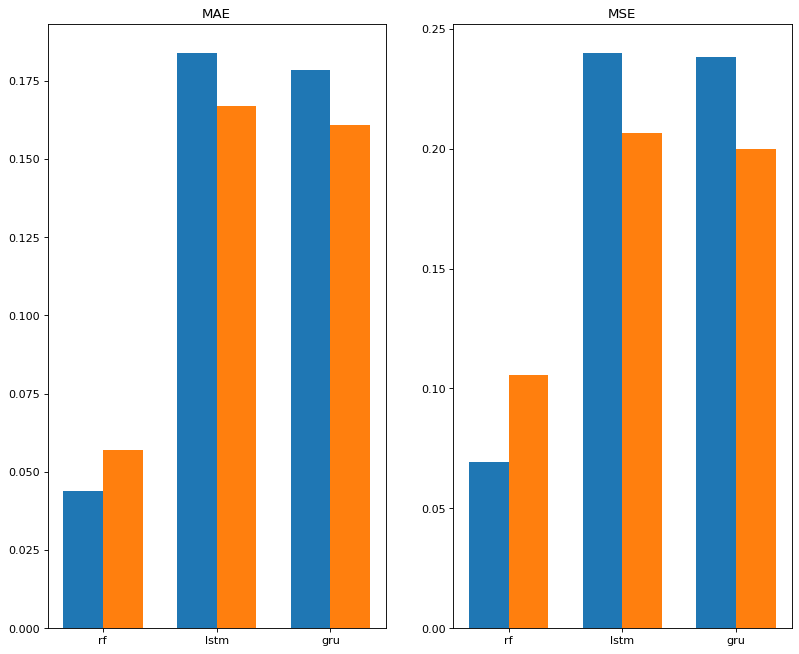

In [90]:
#设置标签
labels = ['rf', 'lstm', 'gru']
width = 0.35 #宽度
p1 = plt.figure(figsize=(12,10) ,dpi=80)  #画布 长宽8:6,分辨率=80

ax1 = p1.add_subplot(1,2,1)  #创建1行3列的子图，开始绘制第一个子图ax1
ax1.bar(np.array(range(3)) - width/2,[train_rf_mae,train_lstm_mae,train_gru_mae],width,label='train')#绘制柱状图
ax1.bar(np.array(range(3)) + width/2,[test_rf_mae,test_lstm_mae,test_gru_mae], width,label='test')
ax1.set_title('MAE')#标题
ax1.set_xticks(np.array(range(3)))#x轴刻度
ax1.set_xticklabels(labels)

ax2 = p1.add_subplot(1,2,2)  #创建1行3列的子图，开始绘制第二个子图ax2
ax2.bar(np.array(range(3)) - width/2,[train_rf_mse,train_lstm_mse,train_gru_mse], width,tick_label=labels,label='train')
ax2.bar(np.array(range(3)) + width/2,[test_rf_mse,test_lstm_mse,test_gru_mse], width, tick_label=labels,label='test')
ax2.set_title('MSE')
ax2.set_xticks(np.array(range(3)))
ax2.set_xticklabels(labels)

# ax3 = p1.add_subplot(1,3,3)  #创建1行3列的子图，开始绘制第三个子图ax3
# ax3.bar(np.array(range(3)) - width/2,[train_rf_mape,train_lstm_mape,train_gru_mape], width,tick_label=labels,label='train')
# ax3.bar(np.array(range(3)) + width/2,[test_rf_mape,test_lstm_mape,test_gru_mape], width, tick_label=labels,label='test')
# ax3.set_title('MAPE')
# ax3.set_xticks(np.array(range(3)))
# ax3.set_xticklabels(labels)
